In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import functools as fc
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal

In [45]:
from collections import deque

class Basis():
    """Making coefficient array of given polynomial"""
    
    def __init__(self, p=3, mode='chebyshev', left_border=0.0, right_border=1.0):
        self.mode = mode
        self.P = p
        self.coef = []
        self.left_border = left_border
        self.right_border = right_border
        if (mode == 'chebyshev'):
            deg = deque([1.0])
            for i in range(self.P):
                cheb = np.polynomial.chebyshev.Chebyshev(deg)
                self.coef.append(list(np.polynomial.chebyshev.cheb2poly(cheb.coef))[::-1])
                deg.appendleft(0)
                
        elif (mode == 'ordinary'):
            deg = deque([1.0])
            for i in range(self.P):
                self.coef.append(list(deg)[::-1])
                deg.appendleft(0)
        
        else:
            raise ValueError(f"There is no mode: {mode}")
            
    def calc(self, p, x):
        if ((p >= self.P) or not isinstance(p, int) or p < 0):
            raise ValueError(f"Degree must be non-negative integer less than {self.P}!")
        value = 0
        #print(self.coef[p])
        for i in self.coef[p]:
            value *= x
            value += i
        return value
    
    def matrix(self, x):
        F = []
        for i in range(len(x)):
            line = [0]*self.P
            for j in range(self.P):
                line[j] = self.calc(j, x[i])
            F.append(line)
            
        return F
    
    def draw(self):
        plt.figure(num = None, figsize = (6, 4), dpi = 250)
        plt.title(self.mode)
        x = np.linspace(self.left_border, self.right_border, 100)
        for degree in range(self.P):
            plt.plot(x, self.calc(degree, x), linewidth = 1.0, label = f'{degree}')

In [273]:
#remember that convolve reverses filter
#2q+1 must be equal for beta and gamma
class TOMP:
    def __init__(self, R, M, P, Basis):
        data_2 = scipy.io.loadmat('h_conv.mat')
        self.h_conv = data_2['h_conv'][0]
        self.R = R
        self.M = M
        self.P = P
        self.Basis = Basis
        
    def _FIR(self, x):
        return np.convolve(x, self.h_conv, mode='valid')
    
    #add reduction for all np.muptiply and * and + operations in order to enable different delays
    def derivative_gamma(self, r0, m0, q0, x, beta, gamma, h):
        r1 = [np.convolve(x, beta[r0], mode='valid')]
        r2 = x[q0:]
        size_gamma=gamma[r0][m0].shape[0]
        if -(size_gamma-q0-1)!=0:
            r2 = r2[:-(size_beta-q0-1)]
        r1.append(r2)
        
        r1.extend([np.convolve(np.dot(self.Basis.matrix(x), h[r0][m]), gamma[r0][m], mode='valid') 
                      for m in range(self.M) if m != m0])
        
        return self._FIR(fc.reduce(np.multiply, np.array(r1)))
    
    def grad_gamma(self, x, beta, gamma, h):
        return [
            [
                [
                    self.derivative_gamma(r0, m0, q0, x, beta, gamma, h)
                for q0 in range(gamma[r0][m0].shape[0])]
            for m0 in range(self.M)]
        for r0 in range(self.R)]
    
    def gradient_gamma(self, x, beta, gamma, h, d, y):
        a = self.grad_gamma(x=x, beta=beta, gamma=gamma, h=h)
        G = np.conjugate(a)
        padding = int((d.shape[0]-y.shape[0])/2)
        if padding!=0:
            d = d[padding:-padding]
        res = y-d
        gradient = np.tensordot(G, res , [[3], [0]])
        
        return gradient
    
    
    
    def derivative_beta(self, r0, q0, x, beta, gamma, h):
        r1 = [np.convolve(np.dot(self.Basis.matrix(x), h[r0][m]), gamma[r0][m], mode='valid') for m in range(self.M)]
        size_beta = beta[r0].shape[0]
        r2 = x[q0:]
        if -(size_beta-q0-1)!=0:
            r2 = r2[:-(size_beta-q0-1)]
        r1.append(r2)
        return self._FIR(fc.reduce(np.multiply, np.array(r1)))
    
    def grad_beta(self, x, beta, gamma, h):
        return [
                [
                    self.derivative_beta(r0, q0, x, beta, gamma, h) 
                for q0 in range(beta[r0].shape[0])]
            for r0 in range(self.R)]
    
    def gradient_beta(self, x, beta, gamma, h, d , y):
        a = self.grad_beta(x=x, beta=beta, gamma=gamma, h=h)
        G = np.conjugate(a)
        padding = int((d.shape[0]-y.shape[0])/2)
        if padding!=0:
            d = d[padding:-padding]
        res = y-d
        gradient = np.tensordot(G, res , [[2], [0]])
        
        return gradient
    
    
    def derivative_h(self, r0, p0, m0, x, beta, gamma, h):
        r1 = np.convolve(x, beta[r0], mode='valid')
        r2 = np.convolve(np.array(self.Basis.matrix(x))[:,p0], gamma[r0][m0], mode='valid')
        r = [r1, r2]
        r.extend([np.convolve(np.dot(self.Basis.matrix(x), h[r0][m]), gamma[r0][m], mode='valid') 
                      for m in range(self.M) if m != m0])
        
        return self._FIR(fc.reduce(np.multiply, np.array(r)))
    def grad_h(self, x, beta, gamma, h):
        return np.array(
        [
            [
                [
                    self.derivative_h(r0, p0, m0, x, beta, gamma, h)
                for p0 in range(self.P)]
            for m0 in range(self.M)]
        for r0 in range(self.R)])
    
    def gradient_h(self, x, beta, gamma, h, d, y):
        a = self.grad_h(x=x, beta=beta, gamma=gamma, h=h)
        G = np.conjugate(a)
        padding = int((d.shape[0]-y.shape[0])/2)
        if padding!=0:
            d = d[padding:-padding]
        res = y-d
        gradient = np.tensordot(G, res , [[3], [0]])
        
        return gradient
    
    def calc_single(self, x, beta, gamma, h, r):
        r1 = [convolve(x, beta[r], mode='valid')]
        r2 = [np.convolve(np.dot(self.Basis.matrix(x), h[r][m]), gamma[r][m], mode='valid') for m in range(self.M)]
        r1.extend(r2)
        
        return self._FIR(fc.reduce(np.multiply, np.array(r1)))
    
    def calc(self, x, beta, gamma, h):
        return fc.reduce(np.add, [self.calc_single(x, beta, gamma, h, r) for r in range(self.R)])

In [274]:
data = scipy.io.loadmat('BlackBoxData.mat')
x = data['x'][0]/2**15
y = data['y'][0]/2**15  # выходной сигнал из усилителя

d = x - y  # поскольку необходимо моделировать ошибку отн. x


In [275]:
P = 20
mode = 'chebyshev'
left_border = 0.0
right_border = 1.0

b = Basis(p=P, mode=mode, left_border=left_border, right_border=right_border)

In [276]:
beta = np.array([[1]])
gamma = np.array([[[1]]])
h = np.ones([1, 1, P])

t = TOMP(R=1, M=1, P=P, Basis=b)

In [277]:
x = x[:100]
d = d[:100]


res = t.calc(beta=beta, gamma=gamma, h=h, x=x)
grad_h = t.gradient_h(x=x, beta=beta, gamma=gamma, h=h, d=d, y=res)
grad_beta = t.gradient_beta(x=x, beta=beta, gamma=gamma, h=h, d=d, y=res)
grad_gamma = t.gradient_gamma(x=x, beta=beta, gamma=gamma, h=h, d=d, y=res)

In [278]:
grad_gamma

array([[[-2.12423623e-07+2.1248669e-09j]]])

In [135]:
f_x, P_x = signal.welch(x, nperseg = 2048)
f_x, P_x = zip(*sorted(zip(f_x, P_x)))

f_d, P_d = signal.welch(d, nperseg = 2048)
f_d, P_d = zip(*sorted(zip(f_d, P_d)))

f_r, P_r = signal.welch(res, nperseg = 2048)
f_r, P_r = zip(*sorted(zip(f_r, P_r)))

/home/alexander/computerScience/ides/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2048 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))
/home/alexander/computerScience/ides/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/home/alexander/computerScience/ides/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2048 is greater than input length  = 68, using nperseg = 68
  .format(nperseg, input_length))


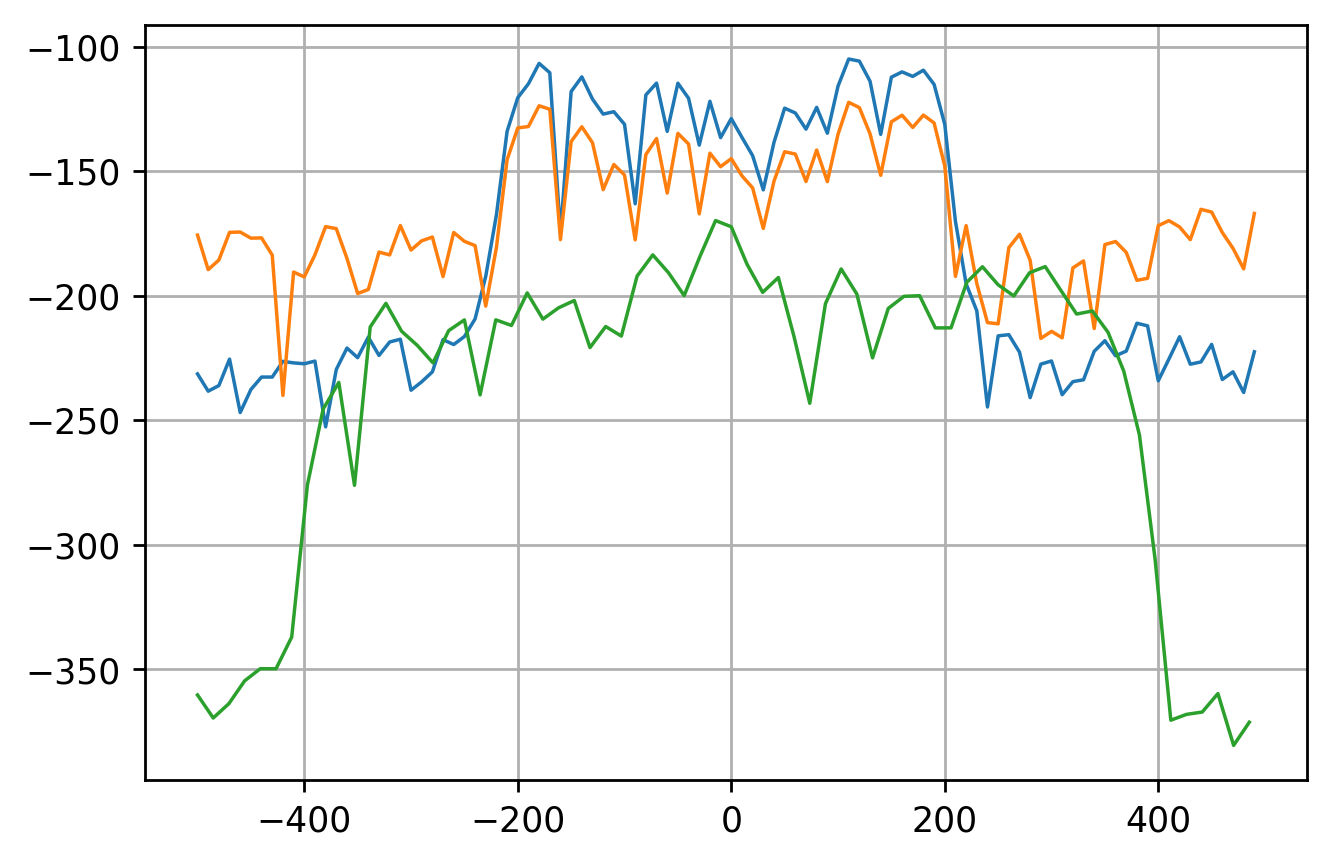

In [136]:
plt.figure(num = None, figsize = (6, 4), dpi = 250)

plt.plot(1000 * np.array(f_x), 10 * np.log(P_x), linewidth = 1.0, label = 'x')
plt.plot(1000 * np.array(f_d), 10 * np.log(P_d), linewidth = 1.0, label = 'd')
plt.plot(1000 * np.array(f_r), 10 * np.log(P_r), linewidth = 1.0, label = 'r')
plt.grid()
plt.show()

In [212]:
a = np.array([1, 2, 3, 4, 5])

In [222]:
a[2:-0]

array([], dtype=int64)